# Reducing Algorithmic Bias in LLM-Driven Loan Decision Systems using Multi-Agent Prompt Optimization

## Uploading Necessary Libraries

In [289]:
!pip install pandas scikit-learn openai
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import statsmodels.api as sm
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score



# Data Proccessing

In [264]:
data = pd.read_csv("Georgia Dataset (2024).csv", low_memory=False)

#making some features constant to reduce noise and to focus on race analysis:
data = data[data["derived_loan_product_type"] == "Conventional:First Lien"]
data = data[data["derived_dwelling_category"] == "Single Family (1-4 Units):Site-Built"]
data = data[data["conforming_loan_limit"] == "C"]
data = data[data["loan_purpose"] == 1]
data = data[data["reverse_mortgage"] == 2]
data = data[data["open-end_line_of_credit"] == 2]
data = data[data["business_or_commercial_purpose"] == 2]
data = data[data["occupancy_type"] == 1]
data = data[data["derived_sex"] == "Male"]
data = data[data["loan_term"] == "360"] ## only 30 year fixed term loans


data = data[data["action_taken"].isin([1, 3])]


columns_to_drop = [
    'activity_year', 'lei', 'lien_status', 'purchaser_type', 'derived_msa-md', 'loan_type', 'state_code', 'county_code', 'census_tract',
    'derived_ethnicity', 'preapproval', 'total_points_and_fees',
    'origination_charges', 'discount_points', 'lender_credits',
    'prepayment_penalty_term', 'intro_rate_period', 'negative_amortization',
    'interest_only_payment', 'balloon_payment', 'other_nonamortizing_features',
    'construction_method', 'manufactured_home_secured_property_type',
    'manufactured_home_land_property_interest', 'total_units',
    'multifamily_affordable_units', 'applicant_credit_score_type',
    'co-applicant_credit_score_type', 'applicant_ethnicity-1', 'applicant_ethnicity-2',
    'applicant_ethnicity-3', 'applicant_ethnicity-4', 'applicant_ethnicity-5',
    'co-applicant_ethnicity-1', 'co-applicant_ethnicity-2', 'co-applicant_ethnicity-3',
    'co-applicant_ethnicity-4', 'co-applicant_ethnicity-5', 'applicant_ethnicity_observed',
    'co-applicant_ethnicity_observed', 'applicant_race-1', 'applicant_race-2',
    'applicant_race-3', 'applicant_race-4', 'applicant_race-5', 'co-applicant_race-1',
    'co-applicant_race-2', 'co-applicant_race-3', 'co-applicant_race-4',
    'co-applicant_race-5', 'applicant_race_observed', 'co-applicant_race_observed',
    'applicant_sex', 'co-applicant_sex', 'applicant_sex_observed', 'co-applicant_sex_observed',
    'applicant_age_above_62', 'co-applicant_age', 'co-applicant_age_above_62',
    'submission_of_application', 'initially_payable_to_institution',
    'aus-1', 'aus-2', 'aus-3', 'aus-4', 'aus-5', 'denial_reason-1', 'denial_reason-2',
    'denial_reason-3', 'denial_reason-4', 'tract_population', 'tract_minority_population_percent',
    'ffiec_msa_md_median_family_income', 'tract_to_msa_income_percentage',
    'tract_owner_occupied_units', 'tract_one_to_four_family_homes',
    'tract_median_age_of_housing_units', 'interest_rate', 'total_loan_costs', 'rate_spread']

data = data.drop(columns=columns_to_drop)

data = data.dropna(subset=[
    "loan_amount",
    "loan_to_value_ratio",
    "loan_term",
    "income",
    "debt_to_income_ratio",
    "derived_race",
    "derived_sex",
    "loan_purpose",
    "occupancy_type",
    "property_value",
    "applicant_age"
])

##making sure age is a number not a range:
def extract_lower_bound(age):
    if pd.isnull(age):
        return np.nan
    age_str = str(age)
    if '-' in age_str:
        parts = age_str.split('-')
        return (float(parts[0]) + float(parts[1])) / 2
    elif '<' in age_str:
        return float(age_str.replace('<', '')) - 1
    elif '>' in age_str:
        return float(age_str.replace('>', '')) + 1
    else:
        try:
            return float(age_str)
        except:
            return np.nan
data["applicant_age"] = data["applicant_age"].apply(extract_lower_bound)


#same thing for debt to income ratios (making sure its not a range):
def clean_range_value(val):
    if pd.isnull(val):
        return np.nan
    val_str = str(val).replace('%', '').replace('<', '').replace('>', '').strip()
    
    try:
        if '-' in val_str:
            parts = val_str.split('-')
            return (float(parts[0].strip()) + float(parts[1].strip())) / 2
        return float(val_str)
    except:
        return np.nan

data["debt_to_income_ratio"] = data["debt_to_income_ratio"].apply(clean_range_value)


data = data[data["derived_race"].isin(["White", "Black or African American"])].copy()

features = ["income", "loan_amount", "loan_to_value_ratio", "debt_to_income_ratio", "property_value"]
data[features] = data[features].apply(pd.to_numeric, errors="coerce")

# Remove outliers using IQR before filtering
def remove_outliers_iqr(df, features):
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[feature] >= lower) & (df[feature] <= upper)]
    return df
data = remove_outliers_iqr(data, ["income", "loan_amount", "loan_to_value_ratio", "debt_to_income_ratio", "property_value"])

data = data.reset_index(drop=False)
data.head()


,index,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_race,derived_sex,action_taken,loan_purpose,reverse_mortgage,open-end_line_of_credit,business_or_commercial_purpose,loan_amount,loan_to_value_ratio,hoepa_status,loan_term,property_value,occupancy_type,income,debt_to_income_ratio,applicant_age
0,67,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Black or African American,Male,1,1,2,2,2,175000.0,97.64,2,360,185000,1,40.0,40.0,39.5
1,69,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,White,Male,1,1,2,2,2,275000.0,101.10,2,360,275000,1,86.0,33.0,39.5
2,76,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,White,Male,3,1,2,2,2,185000.0,97.00,3,360,185000,1,73.0,46.0,39.5
3,87,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,White,Male,1,1,2,2,2,185000.0,97.00,2,360,185000,1,41.0,43.0,29.5
4,91,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Black or African American,Male,3,1,2,2,2,75000.0,90.00,3,360,85000,1,31.0,33.0,59.5


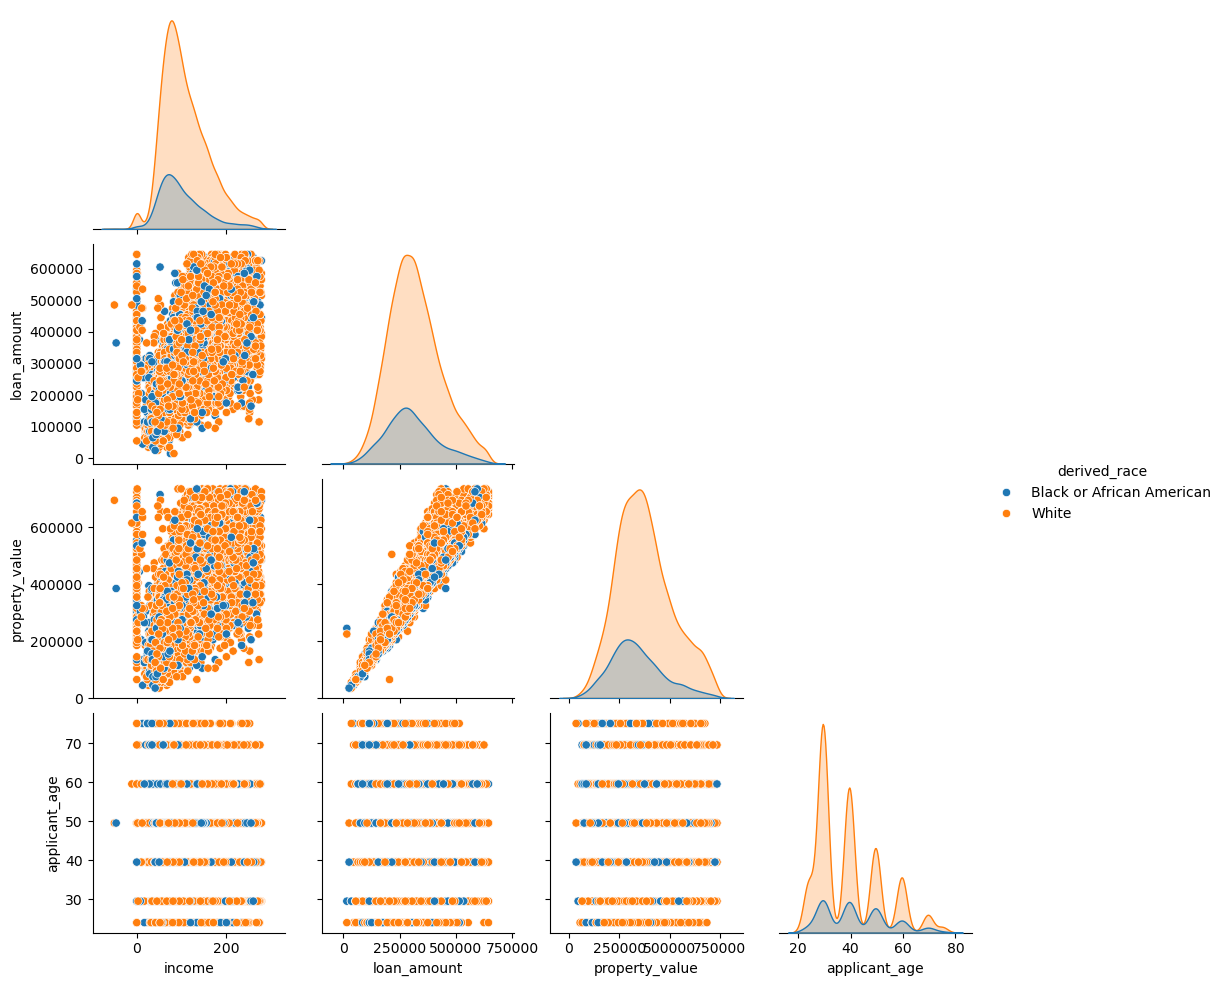

In [268]:
sns.pairplot(data[[
    "income", "loan_amount", "property_value", "applicant_age", "derived_race"
]], hue="derived_race", corner=True)


Notes: we can see that the data is significantly unbalanced between black and white applicants ( White applicants ≈ 9k, Black applicants ≈ 2k), hence we now we apply stratified sampling within key financial feature bins (e.g., income, loan amount, loan-to-value) to construct a balanced subsample. This allows us to control for confounding financial characteristics and isolate the effect of race more accurately. The resulting logistic regression coefficient on the Black dummy remains valid, as we are not modifying the data but rather analyzing a representative and fair subset.

In [270]:
features_to_bin = ["income", "loan_amount", "property_value", "debt_to_income_ratio", "loan_to_value_ratio", "applicant_age"]
n_bins = 4
# the data is being strucutred into 4 bins
data = data.dropna(subset=features_to_bin)

for feature in features_to_bin:
    data[f"{feature}_bin"] = pd.qcut(data[feature], q=n_bins, duplicates='drop')

data["bin_combination"] = data[[f"{f}_bin" for f in features_to_bin]].astype(str).agg("_".join, axis=1)
matched = []

for bin_value in data["bin_combination"].unique():
    bin_group = data[data["bin_combination"] == bin_value]
    black_group = bin_group[bin_group["derived_race"] == "Black or African American"]
    white_group = bin_group[bin_group["derived_race"] == "White"]
    min_count = min(len(black_group), len(white_group))
    if min_count > 0:
        matched.append(black_group.sample(n=min_count, random_state=42))
        matched.append(white_group.sample(n=min_count, random_state=42))

matched_data = pd.concat(matched).sample(frac=1, random_state=42).reset_index(drop=True)
data = matched_data.copy()
data = data.drop(columns=['bin_combination'] + [col for col in data.columns if col.endswith('_bin')])



In [272]:
display( 
    pd.crosstab(matched_data["income_bin"], matched_data["derived_race"]),
    pd.crosstab(matched_data["applicant_age_bin"], matched_data["derived_race"]),
    pd.crosstab(matched_data["loan_amount_bin"], matched_data["derived_race"])
)

derived_race,Black or African American,White
income_bin,,
"(-50.001, 70.0]",650,650
"(70.0, 96.0]",516,516
"(96.0, 136.0]",464,464
"(136.0, 278.0]",442,442


derived_race,Black or African American,White
applicant_age_bin,,
"(23.999, 29.5]",752,752
"(29.5, 39.5]",608,608
"(39.5, 49.5]",398,398
"(49.5, 75.0]",314,314


derived_race,Black or African American,White
loan_amount_bin,,
"(14999.999, 235000.0]",610,610
"(235000.0, 305000.0]",555,555
"(305000.0, 385000.0]",456,456
"(385000.0, 645000.0]",451,451


We performed stratified matching across racial groups by binning key financial and demographic features (income, loan amount, property value, DTI, LTV, and age) into quantile-based ranges. Within each bin, we sampled an equal number of Black and White applicants to ensure balanced representation across the full distribution of each feature. This approach avoids altering the data (unlike normalization) and creates a fair, matched dataset for evaluating model bias, while maintaining realistic value ranges.


# Viewing The Finalized Dataset
-----------------------------

In [274]:
data.head()

,index,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_race,derived_sex,action_taken,loan_purpose,reverse_mortgage,open-end_line_of_credit,business_or_commercial_purpose,loan_amount,loan_to_value_ratio,hoepa_status,loan_term,property_value,occupancy_type,income,debt_to_income_ratio,applicant_age
0,210352,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,White,Male,1,1,2,2,2,505000.0,95.0,2,360,535000,1,263.0,45.0,39.5
1,126798,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,White,Male,1,1,2,2,2,235000.0,95.0,2,360,255000,1,48.0,49.0,29.5
2,11176,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Black or African American,Male,1,1,2,2,2,305000.0,90.0,2,360,345000,1,101.0,37.0,29.5
3,123556,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,White,Male,1,1,2,2,2,265000.0,95.0,2,360,275000,1,96.0,33.0,24.0
4,128708,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,White,Male,1,1,2,2,2,245000.0,85.0,2,360,285000,1,60.0,39.0,29.5


In [276]:
display(
    data["derived_race"].value_counts(),
    data["action_taken"].value_counts()
)

derived_race
White                        2072
Black or African American    2072
Name: count, dtype: int64

action_taken
1    3666
3     478
Name: count, dtype: int64

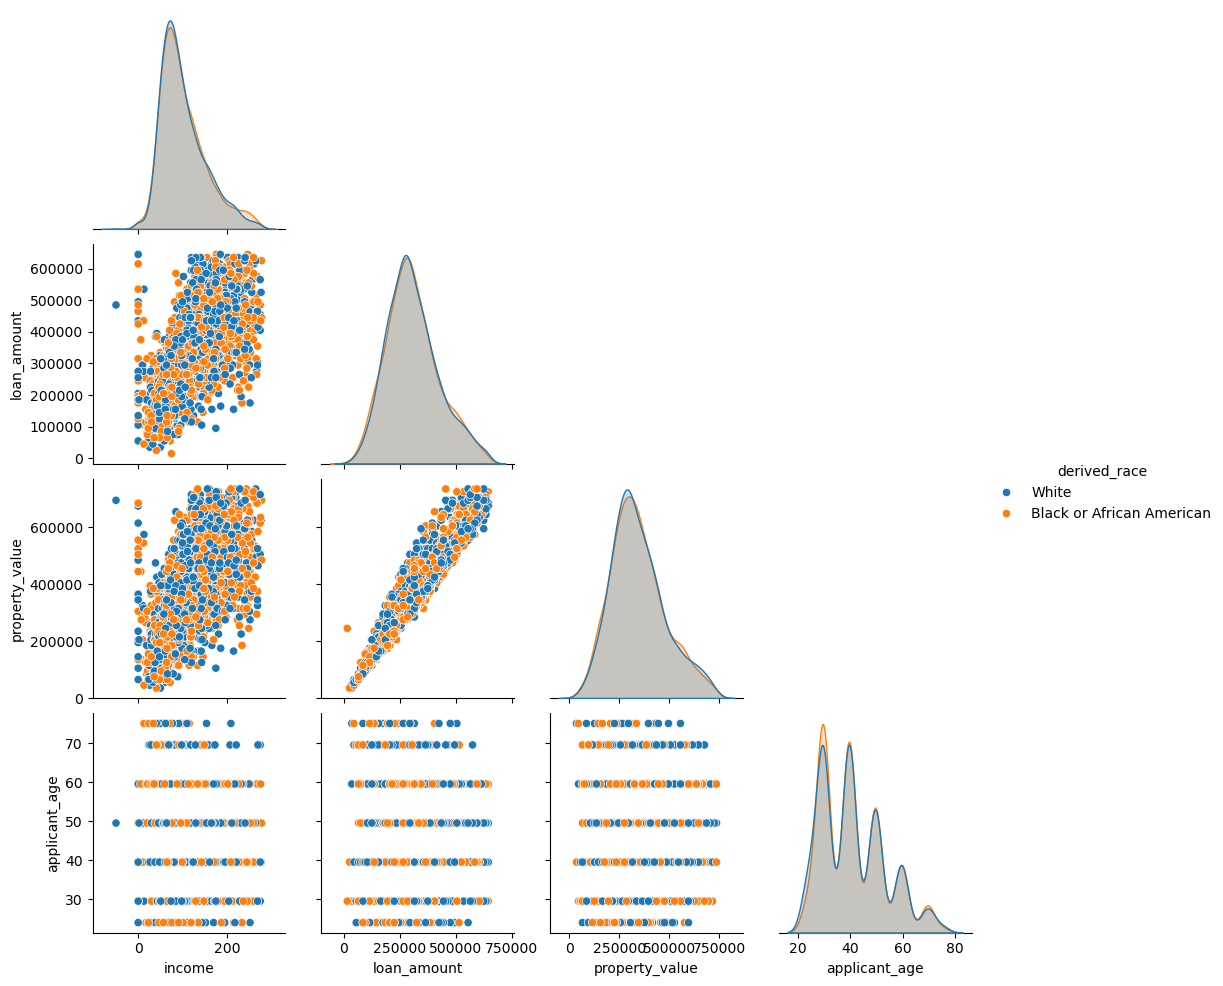

In [278]:
sns.pairplot(data[[
    "income", "loan_amount", "property_value", "applicant_age", "derived_race"
]], hue="derived_race", corner=True)


### As seen, data is now balanced with 2072 applicants from each group with matched fiancnial demographics. Distribution lines refelect nearly perfect matching. 

In [203]:
data.shape

(4144, 23)

In [282]:
## we compute averages:
averages = data.groupby("derived_race")[["loan_amount", "income", "debt_to_income_ratio", "applicant_age"]].mean()
print("Average Loan Amount, Income, and Interest Rate by Race:")
print(averages)


Average Loan Amount, Income, and Interest Rate by Race:
                             loan_amount      income  debt_to_income_ratio  \
derived_race                                                                 
Black or African American  306428.571429  102.141409             40.808398   
White                      307432.432432  101.032819             40.467664   

                           applicant_age  
derived_race                              
Black or African American      41.074566  
White                          40.890685  


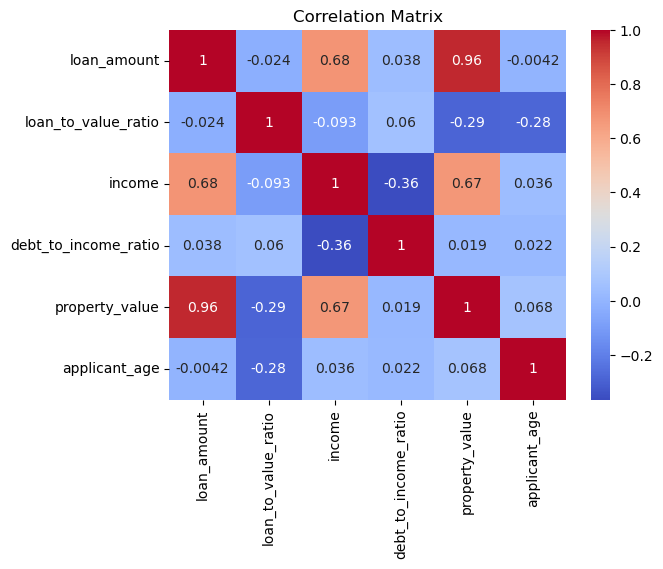

In [284]:
main_features = ["loan_amount", "loan_to_value_ratio", "income", "debt_to_income_ratio", "property_value", "applicant_age"]

corr = data_2[main_features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


The correlation matrix shows economically consistent relationships. There is a strong positive correlation between income and loan amount (0.68), as well as between loan amount and property value (0.96) highlighting that higher-income applicants tend to borrow more and purchase more expensive properties. Income is positively correlated with property value (0.67) and negatively correlated with debt-to-income ratio (−0.36), reinforcing the notion that higher-income borrowers carry lower relative debt burdens.ns.



% of denial per group
derived_race
Black or African American    15.06
White                         8.01
Name: 3, dtype: float64


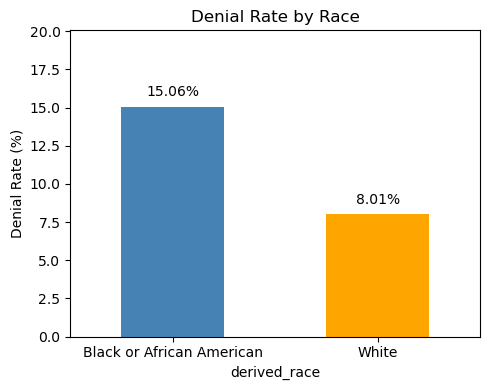

In [287]:
counts = data.groupby("derived_race")["action_taken"].value_counts(normalize=True).unstack()
if 3 in counts.columns:
    denial_rates = counts[3] * 100 
    print("\n% of denial per group")
    print(denial_rates.round(2))

denial_rates = counts[3] * 100
plt.figure(figsize=(5, 4))
denial_rates.plot(kind='bar', color=["steelblue", "orange"])
plt.ylabel("Denial Rate (%)")
plt.title("Denial Rate by Race")
plt.xticks(rotation=0)
plt.ylim(0, denial_rates.max() + 5)
for i, rate in enumerate(denial_rates.round(2)):
    plt.text(i, rate + 0.5, f"{rate:.2f}%", ha='center', va='bottom')
plt.tight_layout()
plt.show()


#### As refelcted, the denial rate now is 15.06% for Black applicants and 8.01% for White applicants. This indicates that the relative bias of morgage lending applications for 1210 financial institutions in the state of Georgia in 2024 after performing stratified matching amounnts to 7.05 percentage points against Black applicants. In other words, white applicants were favoured over black applicants by 7% purely based on race.

#### This underscores that disrimination in financial lending is still a prevelant issue, even in 2024 and even in a progressive state like Georgia. This raises an important question: can large language models (LLMs) offer a fairer alternative to human credit officers in making lending decisions? Lets find out...

### Logit to calcualte Bias (Double Check if results can be useable)

Another way to calculate bias too is using Logistic Regression:

$$
\text{Loan Decision} = \beta_0 + \beta_1 \cdot \text{black} + \beta_2 \cdot \text{income} + \beta_3 \cdot \text{loan\_amount} + \beta_4 \cdot \text{loan\_to\_value\_ratio} + \beta_5 \cdot \text{debt\_to\_income\_ratio} +\beta_6 \cdot \text{applicant\_age} + \beta_7 \cdot \ +\epsilon
$$

#### Explanation:
- **black**: 1 = Black applicant, 0 = White applicant.
- **income, loan_amount, loan_to_value_ratio, debt_to_income_ratio**: Applicant financial features.
- **applicant_age**: Age of the mortgage applicant.
- **β₀**: Base rate for White applicants when all features = 0.
- **β₁**: Effect of being Black relative to White.
- **β₂ to β₇**: Effects of the respective financial and demographic features.
- **ε**: Unexplained variation (error term).
ined variation).

In [401]:
df = data[data["derived_race"].isin(["White", "Black or African American"])].copy()
df["black"] = (df["derived_race"] == "Black or African American").astype(int)
features = ["income", "loan_amount", "loan_to_value_ratio", "debt_to_income_ratio", "applicant_age", "black"]
##property value was dropped as it had high multicollinearity with loan amount as seen in the matrix above)
df["approved"] = (df["action_taken"] == 1).astype(int)

X = df[features]
y = df["approved"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

features_to_scale = ["income", "loan_amount", "loan_to_value_ratio", "debt_to_income_ratio", "applicant_age"]
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
X_test_scaled[features_to_scale] = scaler.transform(X_test[features_to_scale])

#model = LogisticRegression(class_weight='balanced')
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy:", accuracy)


Test set accuracy: 0.9059107358262968


In [383]:
final_dataset = X_train_scaled.reset_index(drop=True).copy()
final_dataset["approved"] = y_train.reset_index(drop=True)
final_dataset.head()


,income,loan_amount,loan_to_value_ratio,debt_to_income_ratio,applicant_age,black,approved
0,2.062570,0.748120,-1.203076,-1.766122,0.713926,1,1
1,0.133677,-0.365455,0.680699,-0.855860,-0.928594,0,1
2,-0.450836,-0.365455,-1.203076,-0.855860,-0.928594,0,1
3,-0.509288,-0.108476,0.643799,-0.059380,-1.380287,1,1
4,2.763986,1.262078,-3.188463,-1.766122,1.535186,1,1


In [385]:

unique, counts = np.unique(y_pred, return_counts=True)
print("Predicted class counts:", dict(zip(unique, counts)))
print(pd.Series(y_pred).value_counts()) 
print(pd.Series(y_pred).value_counts(normalize=True))  


Predicted class counts: {0: 21, 1: 808}
1    808
0     21
Name: count, dtype: int64
1    0.974668
0    0.025332
Name: proportion, dtype: float64


In [387]:
X_sm = sm.add_constant(X_train_scaled)
logit_model = sm.Logit(y_train, X_sm).fit()
print(logit_model.summary())
print(classification_report(y_test, y_pred, zero_division=0))



Optimization terminated successfully.
         Current function value: 0.296865
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               approved   No. Observations:                 3315
Model:                          Logit   Df Residuals:                     3308
Method:                           MLE   Df Model:                            6
Date:                Wed, 30 Jul 2025   Pseudo R-squ.:                  0.1649
Time:                        17:55:10   Log-Likelihood:                -984.11
converged:                       True   LL-Null:                       -1178.4
Covariance Type:            nonrobust   LLR p-value:                 8.048e-81
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    2.9363      0.109     26.884      0.000       2.722       3.150

In [407]:
data.to_csv("Cleaned_Georgia_Mortgage_Data.csv", index=False)